### Regressions incorporating same session and previous session regressions

1/ Across all sessions
2/ Separtately for each wave 
3/ From session to session 

In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os
print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import zscore as zscore_sc
import bambi as bmb
import arviz as az
import bammm_local as mm
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import product, combinations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

trait_factor_names = ["TF1_CognAnxDepr", "TF2_PhysiolAnx", "TF3_NegativeAffect"]
trait_factor_names_short = ["TF1", "TF2",  "TF3",]



mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'Risk',
           'q7_worry_econ_impact': 'EconWorr',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGr',
           'avoid_beh': 'Avoidance',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaVal',
           'q7_period_rel_danger': 'ThreatPerception',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'sticsa_som_sa_currsess': "StateSomAnx",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 
           }

vars = ["Avoidance", "InforSeek", "Risk", 
        "ThreatPerception", "Deaths", "Cases"]

#vars = ["Avoidance", "InforSeek", "Risk", 
#        "ThreatPerception", "Worry", "AvoidAnx", "Deaths", "Cases"]


#vars = ["Avoidance", "InforSeek", "Risk", 
#        "ThreatPerception",  "Deaths"]

df=df.rename(columns=mapdict)
dfall = df.copy()

df = df.loc[:,vars+["PROLIFICID","session"]]#.set_index("PROLIFICID")
# Discretize the numeric vector
bins = [1, 7, 13, 21]
labels = ['spring_wave', 'summer', 'autumn_wave']
df["wave"] = pd.cut(df["session"], bins=bins, labels=labels, right=False, include_lowest=True)

# zscore each variable by session (for regressions)
for v in vars: 
    for s in df.session.unique(): 
      df.loc[df["session"]==s,v] = zscore_sc(np.array(df.loc[df["session"]==s,v]), nan_policy="omit")
    


def demultindex(df):
    df.columns = [ x+"_"+str(y) for x,y in df.columns ]
    return df

# Trait scores in a separate df
df_id = dfall.loc[:,["PROLIFICID"]+trait_factor_names_short].groupby(by="PROLIFICID").mean()

tdf = df.pivot(columns="session", index="PROLIFICID", values=vars)

/data/drive/postdoc/Project4_covid


In [4]:
vars


['Avoidance', 'InforSeek', 'Risk', 'ThreatPerception', 'Deaths', 'Cases']

In [5]:
win=1


for dvidx, dv in enumerate(vars):
    ## Prepare data set 
    regdf = pd.DataFrame()
    for s in np.arange(win+1,21):

        #tdf.loc[:,(dv,[1,2])]
        x_dv = demultindex(tdf.loc[:,(dv,np.arange(s-win,s+1))])
        x_dv = x_dv.rename(columns=dict(zip(x_dv.columns, [dv+"_lag"+str(x) for x in np.arange(win,-1, -1)])))

        x_dv["session"] = s
        x_dv["sess_str"] = "sess"+str(s)
        regdf = pd.concat([regdf, x_dv], axis=0)

    if dvidx == 0:
        fitdf = regdf
    else:
        fitdf = pd.merge(fitdf, regdf,  on=["PROLIFICID", "session"])

bins = [1, 7, 13, 21]
labels = ['spring_wave', 'summer', 'autumn_wave']
fitdf["wave"] = pd.cut(fitdf["session"], bins=bins, labels=labels, right=False, include_lowest=True)

### Create change variables 
for dvidx, dv in enumerate(vars):
    fitdf[dv+"_delta"] = fitdf[dv+"_lag0"] - fitdf[dv+"_lag1"]



In [6]:
fitdf

Avoidance_lag1  Avoidance_lag0  session sess_str_x  \
PROLIFICID                                                             
01S0stEpc3rU6YxK        0.831601        0.898723        2      sess2   
05c9AaLx1V20UAcO        0.416492        0.505449        2      sess2   
07GDvN1Nh0oHcEBM       -0.413725       -0.674372        2      sess2   
0OjnLzK5ABd2wO54        0.831601        0.112175        2      sess2   
0Pe1blVigsBRLvBj       -0.413725       -1.067646        2      sess2   
...                          ...             ...      ...        ...   
zNbLeZqHa6wNHRLR        0.543792        0.493993       20     sess20   
zYWr4nlB9BwdVWFB        0.851200        0.493993       20     sess20   
zZGJnUM65XIz0F0X       -0.071026       -0.715785       20     sess20   
zlOEoLWEAwlLTGbE       -0.378435       -0.715785       20     sess20   
ztPVSoIVH3QKpGeQ        0.236383        0.796437       20     sess20   

                  InforSeek_lag1  InforSeek_lag0 sess_str_y  Risk_lag1  \
PROLIFICID                                                               
01S0stEpc3rU6YxK        0.576341        0.797062      sess2  -0.884059   
05c9AaLx1V20UAcO        0.576341       -0.361594      sess2  -0.391272   
07GDvN1Nh0oHcEBM        0.576341       -0.361594      sess2   1.382759   
0OjnLzK5ABd2wO54        0.576341       -0.361594      sess2   0.101514   
0Pe1blVigsBRLvBj        0.576341        0.797062      sess2  -0.292715   
...                          ...             ...        ...        ...   
zNbLeZqHa6wNHRLR       -0.241170       -0.292770     sess20  -1.370373   
zYWr4nlB9BwdVWFB        0.501097        0.439155     sess20   0.191025   
zZGJnUM65XIz0F0X       -2.467972       -1.756620     sess20  -0.936651   
zlOEoLWEAwlLTGbE       -1.725705       -1.024695     sess20  -1.023395   
ztPVSoIVH3QKpGeQ        0.501097        1.171080     sess20   1.058469   

                  Risk_lag0 sess_str_x  ...  Cases_lag1  Cases_lag0  \
PROLIFICID                              ...                           
01S0stEpc3rU6YxK  -1.109545      sess2  ...   -0.364614   -0.277128   
05c9AaLx1V20UAcO   0.191473      sess2  ...   -0.681464   -0.894667   
07GDvN1Nh0oHcEBM   1.306631      sess2  ...    5.014428    0.020651   
0OjnLzK5ABd2wO54   0.191473      sess2  ...   -0.081184   -0.913035   
0Pe1blVigsBRLvBj  -0.087317      sess2  ...    1.128543    1.858601   
...                     ...        ...  ...         ...         ...   
zNbLeZqHa6wNHRLR  -1.395351     sess20  ...    0.228953   -0.518824   
zYWr4nlB9BwdVWFB   0.284020     sess20  ...   -1.146481    0.197397   
zZGJnUM65XIz0F0X  -0.865023     sess20  ...   -0.736951   -0.543387   
zlOEoLWEAwlLTGbE  -0.776635     sess20  ...   -0.644123    0.193978   
ztPVSoIVH3QKpGeQ   0.991124     sess20  ...   -0.407613   -1.003732   

                 sess_str_y         wave  Avoidance_delta InforSeek_delta  \
PROLIFICID                                                                  
01S0stEpc3rU6YxK      sess2  spring_wave         0.067122        0.220722   
05c9AaLx1V20UAcO      sess2  spring_wave         0.088957       -0.937935   
07GDvN1Nh0oHcEBM      sess2  spring_wave        -0.260647       -0.937935   
0OjnLzK5ABd2wO54      sess2  spring_wave        -0.719425       -0.937935   
0Pe1blVigsBRLvBj      sess2  spring_wave        -0.653921        0.220722   
...                     ...          ...              ...             ...   
zNbLeZqHa6wNHRLR     sess20  autumn_wave        -0.049799       -0.051600   
zYWr4nlB9BwdVWFB     sess20  autumn_wave        -0.357208       -0.061942   
zZGJnUM65XIz0F0X     sess20  autumn_wave        -0.644760        0.711352   
zlOEoLWEAwlLTGbE     sess20  autumn_wave        -0.337351        0.701009   
ztPVSoIVH3QKpGeQ     sess20  autumn_wave         0.560054        0.669983   

                  Risk_delta  ThreatPerception_delta Deaths_delta Cases_delta  
PROLIFICID                                                                     
01S0stEpc3rU6YxK   -0.225486    

### Single model across all sessions

In [8]:
def determine_lag_status(text):
    if 'lag0' in text:
        return 'lag0'
    elif 'lag1' in text:
        return 'lag1'
    else:
        return 'na'

ddf = pd.DataFrame()
fitdf2=fitdf.dropna().join(df_id).reset_index()
for dvidx, dv in enumerate(vars):

    ### Fit lag1 model first, record residuls ###
    dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag1")]) for tf in ["TF1", "TF2", "TF3"] ]
    
    eq = mm.generate_equation(dv+"_delta",  ["session"]+dvs, [""], "reducedrank") 
    md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
    res = md.fit(method=['bfgs'])

    edf = res.conf_int(alpha=0.05)
    edf.columns = ["CI5", "CI95"]
    edf["beta"] = res.params
    edf["dv"] = dv 
    edf["p"] = round(res.pvalues, 4)
    edf["eff_raw"] = edf.index
    edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
    edf["eff_time"] = "lag1"
    edf["indiff"] = edf.index.str.split(":").str[1]
    edf["iv"] = edf.index.str.split("_").str[0]

    fitdf2[dv+"_delta_resid"] = res.resid
    ddf = pd.concat([ddf, edf.reset_index()])


    ### Fot contemporaneous model ###
    dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag0")]) for tf in ["TF1", "TF2", "TF3"] ]
    dvs = [i for i in dvs if dv+"_lag0" not in i]

    eq = mm.generate_equation(dv+"_delta_resid",  ["session"]+dvs, [""], "reducedrank") 
    md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
    res = md.fit(method=['bfgs'])

    edf = res.conf_int(alpha=0.05)
    edf.columns = ["CI5", "CI95"]
    edf["beta"] = res.params
    edf["dv"] = dv 
    edf["p"] = round(res.pvalues, 4)
    edf["eff_raw"] = edf.index
    edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
    edf["eff_time"] = "lag0"
    edf["indiff"] = edf.index.str.split(":").str[1]
    edf["iv"] = edf.index.str.split("_").str[0]

    ddf = pd.concat([ddf, edf.reset_index()])
    

var_to_id = {var: i for i, var in enumerate(vars)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)

In [10]:
ddf.loc[(ddf["eff_type"] == "maineff") & ((ddf["eff_time"] =="lag0") | (ddf["eff_time"] == "na")) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

index       CI5      CI95      beta                dv  \
2          InforSeek_lag0  0.023809  0.067830  0.045820         Avoidance   
9               Risk_lag0  0.003261  0.059981  0.031621         Avoidance   
13  ThreatPerception_lag0  0.045525  0.082675  0.064100         Avoidance   
2          Avoidance_lag0  0.026348  0.078041  0.052195         InforSeek   
13  ThreatPerception_lag0  0.037175  0.077817  0.057496         InforSeek   
2          Avoidance_lag0  0.001640  0.038726  0.020183              Risk   
13  ThreatPerception_lag0  0.039178  0.068139  0.053659              Risk   
2          Avoidance_lag0  0.021776  0.058535  0.040155  ThreatPerception   
9          InforSeek_lag0  0.011787  0.046514  0.029151  ThreatPerception   
13              Risk_lag0  0.006906  0.043005  0.024956  ThreatPerception   
21             Cases_lag0  0.005823  0.046643  0.026233  ThreatPerception   

         p                eff_raw eff_type eff_time indiff                iv  \
2   0.0000         InforSeek_lag0  maineff     lag0    NaN         InforSeek   
9   0.0289              Risk_lag0  maineff     lag0    NaN              Risk   
13  0.0000  ThreatPerception_lag0  maineff     lag0    NaN  ThreatPerception   
2   0.0001         Avoidance_lag0  maineff     lag0    NaN         Avoidance   
13  0.0000  ThreatPerception_lag0  maineff     lag0    NaN  ThreatPerception   
2   0.0329         Avoidance_lag0  maineff     lag0    NaN         Avoidance   
13  0.0000  ThreatPerception_lag0  maineff     lag0    NaN  ThreatPerception   
2   0.0000         Avoidance_lag0  maineff     lag0    NaN         Avoidance   
9   0.0010         InforSeek_lag0  maineff     lag0    NaN         InforSeek   
13  0.0067              Risk_lag0  maineff     lag0    NaN              Risk   
21  0.0118             Cases_lag0  maineff     lag0    NaN             Cases   

    dv_id  iv_id  
2       0    1.0  
9       0    2.0  
13      0    3.0  
2       1    0.0  
13      1    3.0  
2       2    0.0  
13      2    3.0  
2       3    0.0  
9       3    1.0  
13      3    2.0  
21      3    5.0



### Plot same-session relationships

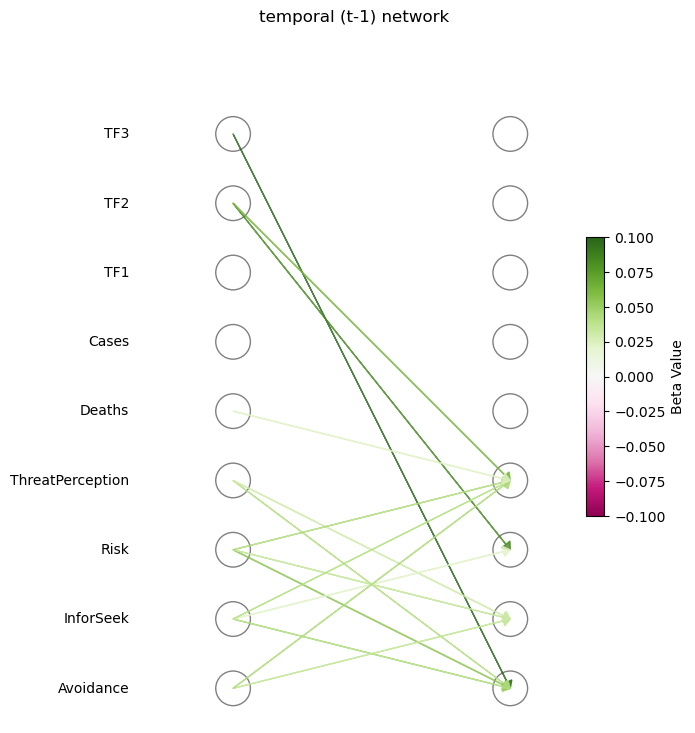

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):

    tddf = ddf.loc[(ddf["eff_type"] == "maineff") & ((ddf["eff_time"] ==lag) | (ddf["eff_time"] == "na")) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

    # Normalize beta values for the colormap, centered on 0 with symmetrical limits
    max_abs_beta = 0.1
    #max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

    # Create a custom colormap
    cmap = plt.get_cmap('PiYG')

    vars_with_tfs = vars + trait_factor_names_short

    var_to_id = {var: i for i, var in enumerate(vars_with_tfs)}
    # Create dv_id and iv_id columns
    tddf['dv_id'] = tddf['dv'].map(var_to_id)
    tddf['iv_id'] = tddf['iv'].map(var_to_id)

    # Grid settings
    n_vars = len(vars_with_tfs)
    circle_radius = 0.25
    arrow_scale = 0.5
    within_wave_dist = 4

    # Adjust figure size for a continuous plot
    fig, ax = plt.subplots(figsize=(8, 9))

    # Draw circles for previous and subsequent columns
    for i in range(n_vars):
        ax.add_patch(plt.Circle((0, i), circle_radius, color='gray', fill=False))
        ax.add_patch(plt.Circle((within_wave_dist, i), circle_radius, color='gray', fill=False))

    # Draw arrows within the continuous sequence
    for index, row in tddf.iterrows():
        dv_id = row['dv_id']
        iv_id = row['iv_id']
        beta = row['beta']
        color = cmap(norm(beta))
        ax.arrow(0, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

    # Add variable labels on the left
    for i, var in enumerate(vars_with_tfs):
        ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')

    # Setting the limits and aspect ratio
    ax.set_xlim(-1.5, within_wave_dist + 1)  # Adjusted the limit to reduce whitespace
    ax.set_ylim(-0.5, n_vars + 0.5)
    ax.set_aspect('equal')

    ax.set_title(lbl+" network")

    # Hide the axes
    ax.axis('off')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.01, aspect=15)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')

    plt.show()



### Plot same session modulations by trait factors

In [12]:
for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):
    fig, ax = plt.subplots(1,3,figsize=(20, 8))
    for id_idx, id in enumerate(trait_factor_names_short):
        tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]==lag) & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]
        #tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]=="lag0") & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") , :]

        # Normalize beta values for the colormap, centered on 0 with symmetrical limits
        max_abs_beta = 0.05
        norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

        # Create a custom colormap
        cmap = plt.get_cmap('PRGn')

        vars_with_tfs = vars 

        # Grid settings
        n_vars = len(vars_with_tfs)
        circle_radius = 0.25
        arrow_scale = 0.5
        within_wave_dist = 3

        

        # Draw circles for previous and subsequent columns
        for i in range(n_vars):
            ax[id_idx].add_patch(plt.Circle((0, i), circle_radius, color='gray', fill=False))
            ax[id_idx].add_patch(plt.Circle((within_wave_dist, i), circle_radius, color='gray', fill=False))

        # Draw arrows within the continuous sequence
        for index, row in tddf.iterrows():
            dv_id = row['dv_id']
            iv_id = row['iv_id']
            beta = row['beta']
            color = cmap(norm(beta))
            ax[id_idx].arrow(0, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

        # Add variable labels on the left
        for i, var in enumerate(vars_with_tfs):
            ax[id_idx].text(-0.5, i, var, verticalalignment='center', horizontalalignment='right')
        
        # Add title
        ax[id_idx].set_title(lbl+" network\Modulation by "+id)

        # Setting the limits and aspect ratio
        ax[id_idx].set_xlim(-1.5, within_wave_dist + 1)  # Adjusted the limit to reduce whitespace
        ax[id_idx].set_ylim(-0.5, n_vars + 0.5)
        ax[id_idx].set_aspect('equal')

        # Hide the axes
        ax[id_idx].axis('off')

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax[2], orientation='vertical', fraction=0.03, pad=0.01, aspect=15)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')

plt.show()


### Split by waves 

In [14]:
ddf = pd.DataFrame()
for w in ['spring_wave', 'summer', 'autumn_wave']:
    fitdf2=fitdf.loc[fitdf["wave"]==w,:].dropna().join(df_id).reset_index()
    for dvidx, dv in enumerate(vars):
        
        ### Fit lag1 model first, record residuls ###
        dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag1")]) for tf in ["TF1", "TF2", "TF3"] ]
        
        eq = mm.generate_equation(dv+"_delta",  ["session"]+dvs, [""], "reducedrank") 
        md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
        res = md.fit(method=['bfgs'])

        edf = res.conf_int(alpha=0.05)
        edf.columns = ["CI5", "CI95"]
        edf["beta"] = res.params
        edf["dv"] = dv 
        edf["wave"] = w
        edf["p"] = round(res.pvalues, 4)
        edf["eff_raw"] = edf.index
        edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
        edf["eff_time"] = edf["eff_raw"].apply(determine_lag_status)
        edf["indiff"] = edf.index.str.split(":").str[1]
        edf["iv"] = edf.index.str.split("_").str[0]

        fitdf2[dv+"_delta_resid"] = res.resid
        ddf = pd.concat([ddf, edf.reset_index()])


        ### Fot contemporaneous model ###
        dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag0")]) for tf in ["TF1", "TF2", "TF3"] ]
        dvs = [i for i in dvs if dv+"_lag0" not in i]

        eq = mm.generate_equation(dv+"_delta_resid",  ["session"]+dvs, [""], "reducedrank") 
        md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
        res = md.fit(method=['bfgs'])

        edf = res.conf_int(alpha=0.05)
        edf.columns = ["CI5", "CI95"]
        edf["beta"] = res.params
        edf["dv"] = dv 
        edf["wave"] = w
        edf["p"] = round(res.pvalues, 4)
        edf["eff_raw"] = edf.index
        edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
        edf["eff_time"] = edf["eff_raw"].apply(determine_lag_status)
        edf["indiff"] = edf.index.str.split(":").str[1]
        edf["iv"] = edf.index.str.split("_").str[0]

        ddf = pd.concat([ddf, edf.reset_index()])

In [15]:
# Map variables to IDs
var_to_id = {var: i for i, var in enumerate(vars)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)



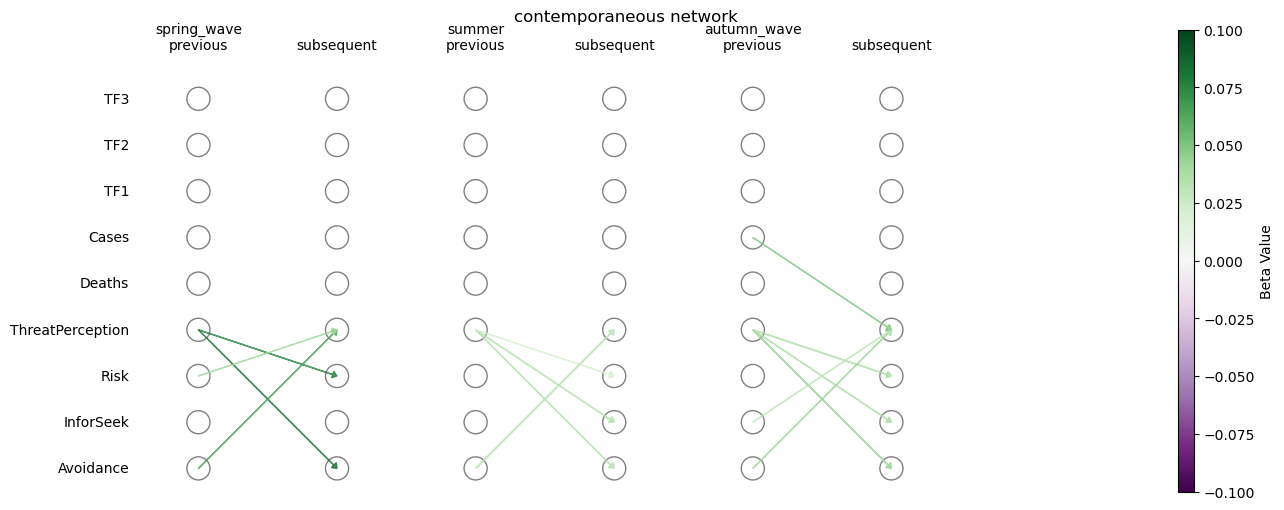

In [16]:
for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):
    tddf = ddf.loc[(ddf["eff_type"] == "maineff") & (ddf["eff_time"]==lag) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

    # Normalize beta values for the colormap, centered on 0 with symmetrical limits
    # max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
    max_abs_beta = 0.1
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

    # Create a custom colormap
    cmap = plt.get_cmap('PRGn')

    vars_with_tfs = vars + trait_factor_names_short

    # Grid settings
    waves = ['spring_wave', 'summer', 'autumn_wave']
    n_waves = len(waves)
    n_vars = len(vars_with_tfs)
    circle_radius = 0.25
    arrow_scale = 0.5
    within_wave_dist = 3

    # Adjust figure size for wider plot
    fig, ax = plt.subplots(figsize=(n_waves * 12, 6))

    # Draw circles for previous and subsequent columns
    for w, wave in enumerate(waves):
        base_x = w * 6  # Increased gap between waves
        for i in range(n_vars):
            ax.add_patch(plt.Circle((base_x, i), circle_radius, color='gray', fill=False))
            ax.add_patch(plt.Circle((base_x + within_wave_dist, i), circle_radius, color='gray', fill=False))  # Doubled the distance

    # Draw arrows within each wave
    for index, row in tddf.iterrows():
        wave_from = row['wave']
        w = waves.index(wave_from)
        base_x = w * 6
        dv_id = row['dv_id']
        iv_id = row['iv_id']
        beta = row['beta']
        color = cmap(norm(beta))
        ax.arrow(base_x, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

    # Add variable labels on the left
    for i, var in enumerate(vars_with_tfs):
        ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')  # Reduced the whitespace by half

    # Add wave names and column labels
    for w, wave in enumerate(waves):
        base_x = w * 6
        ax.text(base_x, n_vars, wave + "\nprevious", horizontalalignment='center', verticalalignment='bottom')
        ax.text(base_x + within_wave_dist, n_vars, "subsequent", horizontalalignment='center', verticalalignment='bottom')  # Adjusted the position

    # Setting the limits and aspect ratio
    ax.set_xlim(-1.5, n_waves * 6 + 2)  # Adjusted the limit to reduce whitespace
    ax.set_ylim(-0.5, n_vars + 0.5)
    ax.set_aspect('equal')
    ax.set_title(lbl+ " network")

    # Hide the axes
    ax.axis('off')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, aspect=30)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')

    plt.show()

In [54]:
ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]=="lag1"),]

index       CI5      CI95      beta         dv         wave  \
4   Avoidance_lag1:TF1 -0.043325  0.074433  0.015554  Avoidance  spring_wave   
6   Avoidance_lag1:TF2 -0.022127  0.073270  0.025571  Avoidance  spring_wave   
8   Avoidance_lag1:TF3 -0.106300  0.003320 -0.051490  Avoidance  spring_wave   
10  InforSeek_lag1:TF1 -0.024909  0.085453  0.030272  Avoidance  spring_wave   
11  InforSeek_lag1:TF2 -0.059716  0.019546 -0.020085  Avoidance  spring_wave   
..                 ...       ...       ...       ...        ...          ...   
23     Deaths_lag1:TF2  0.014296  0.107130  0.060713      Cases  autumn_wave   
24     Deaths_lag1:TF3 -0.002918  0.121114  0.059098      Cases  autumn_wave   
26      Cases_lag1:TF1  0.007170  0.140754  0.073962      Cases  autumn_wave   
27      Cases_lag1:TF2 -0.099586 -0.005681 -0.052634      Cases  autumn_wave   
28      Cases_lag1:TF3 -0.099800  0.014994 -0.042403      Cases  autumn_wave   

         p             eff_raw     eff_type eff_time indiff         iv  dv_id  \
4   0.6046  Avoidance_lag1:TF1  interaction     lag1    TF1  Avoidance      0   
6   0.2934  Avoidance_lag1:TF2  interaction     lag1    TF2  Avoidance      0   
8   0.0656  Avoidance_lag1:TF3  interaction     lag1    TF3  Avoidance      0   
10  0.2823  InforSeek_lag1:TF1  interaction     lag1    TF1  InforSeek      0   
11  0.3206  InforSeek_lag1:TF2  interaction     lag1    TF2  InforSeek      0   
..     ...                 ...          ...      ...    ...        ...    ...   
23  0.0104     Deaths_lag1:TF2  interaction     lag1    TF2     Deaths      5   
24  0.0618     Deaths_lag1:TF3  interaction     lag1    TF3     Deaths      5   
26  0.0300      Cases_lag1:TF1  interaction     lag1    TF1      Cases      5   
27  0.0280      Cases_lag1:TF2  interaction     lag1    TF2      Cases      5   
28  0.1476      Cases_lag1:TF3  interaction     lag1    TF3      Cases      5   

    iv_id  
4     0.0  
6     0.0  
8     0.0  
10    1.0  
11    1.0  
..    ...  
23    4.0  
24    4.0  
26    5.0  
27    5.0  
28    5.0  

[324 rows x 14 columns]

### plot modulation by TFs by wave 

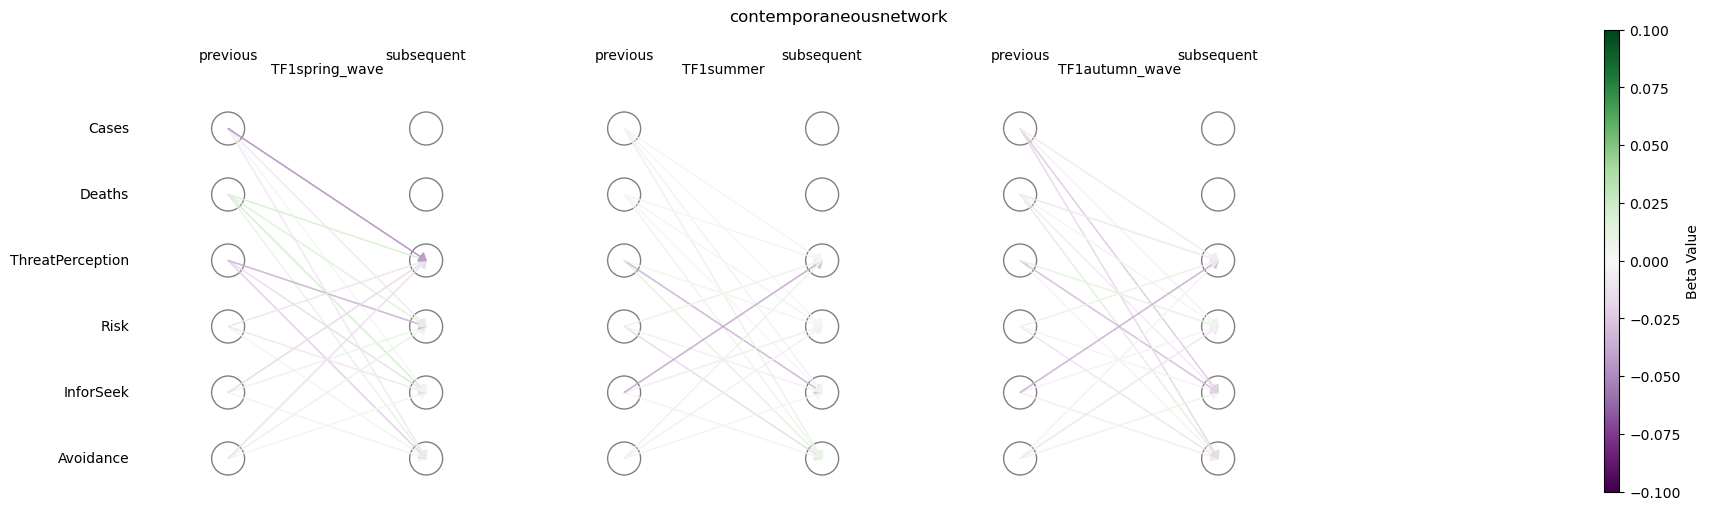

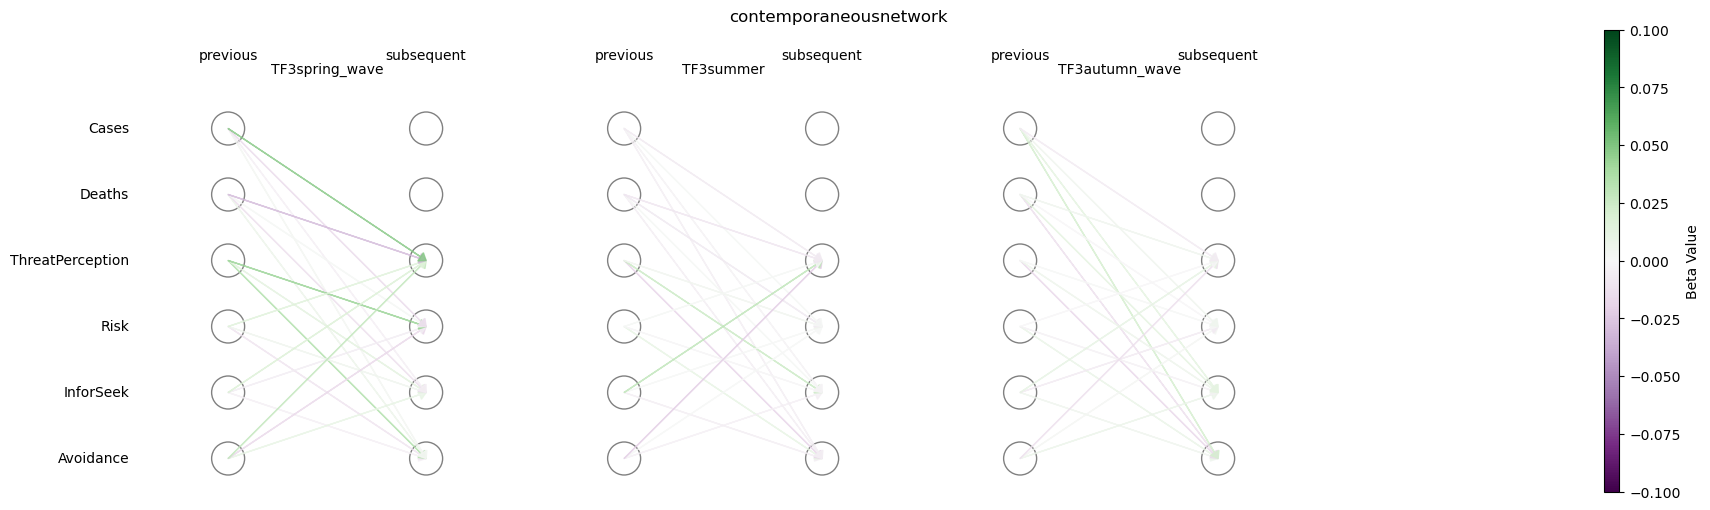

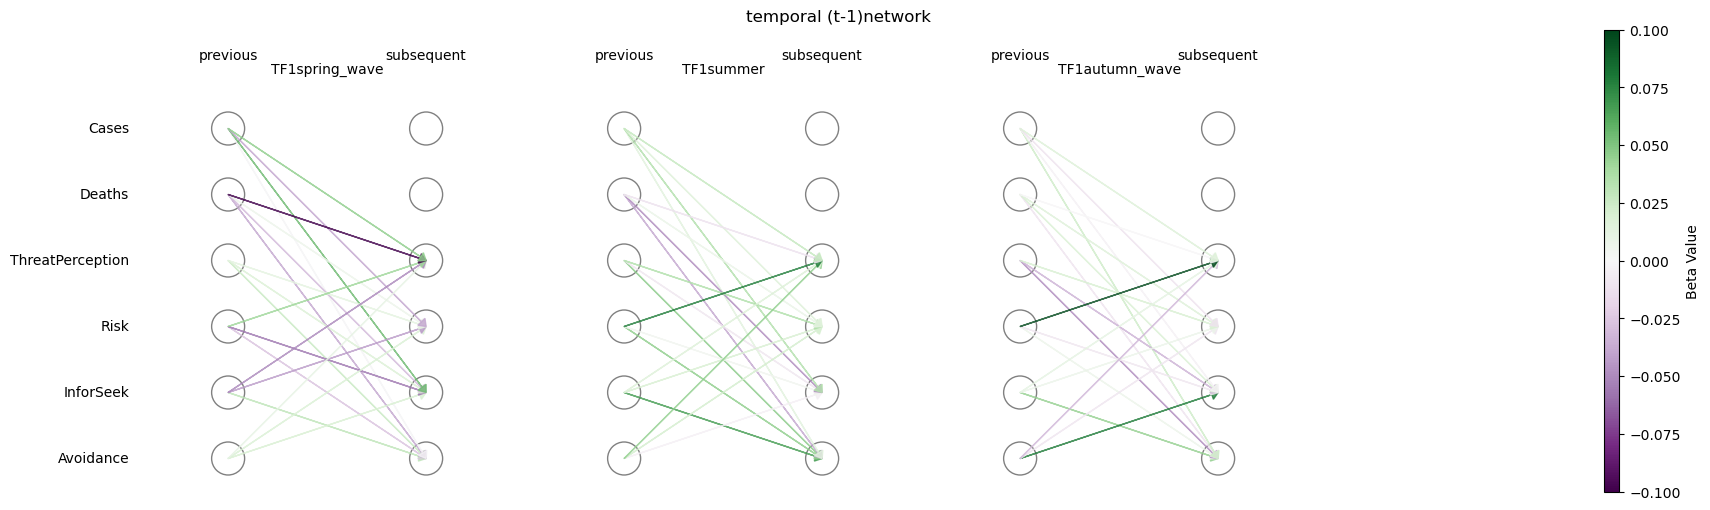

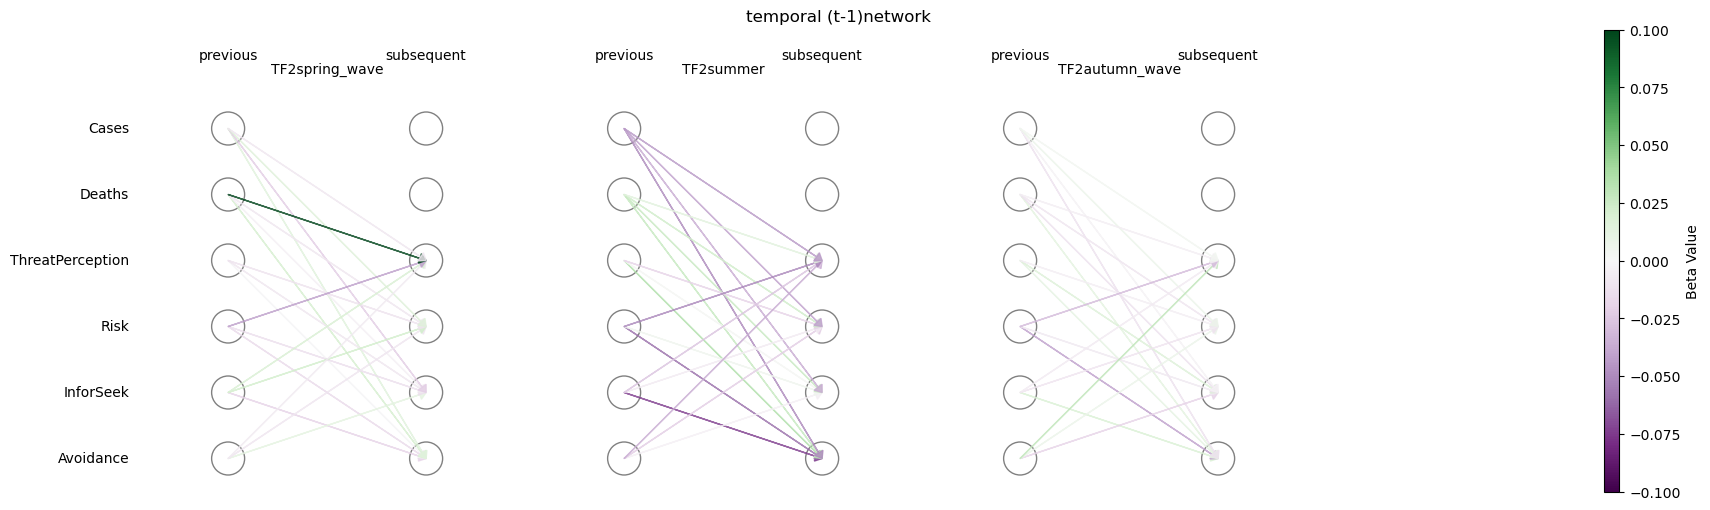

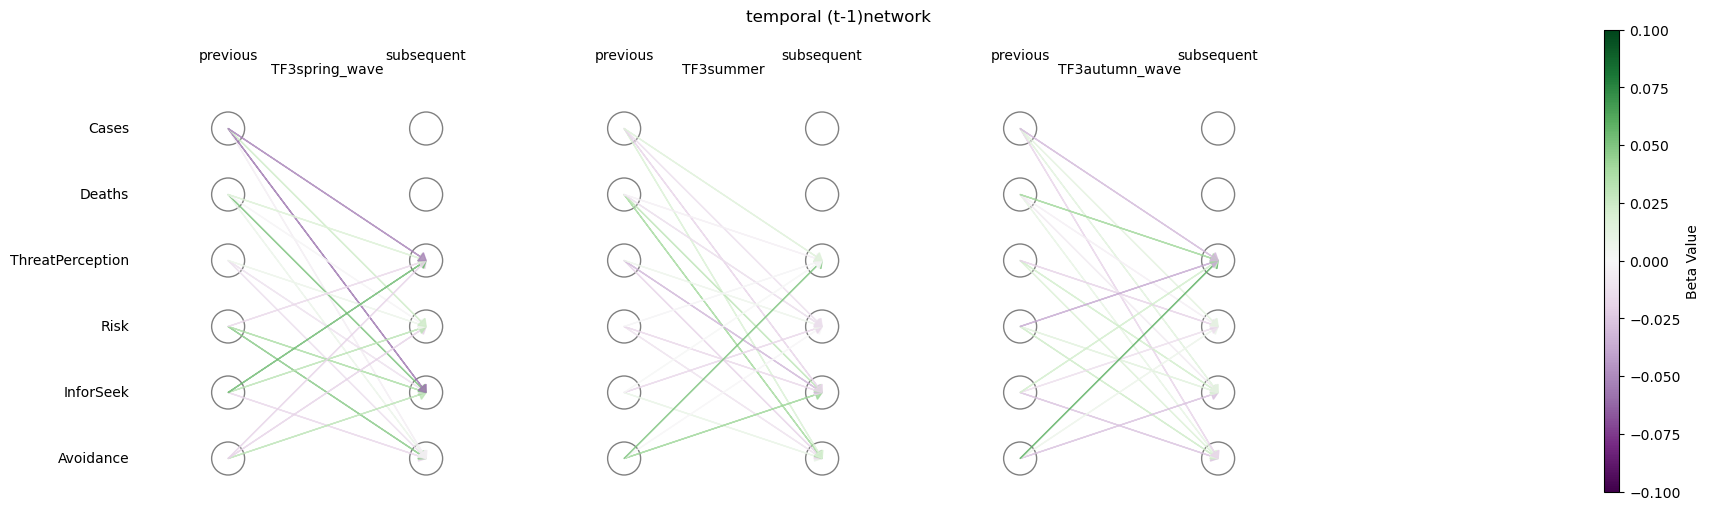

In [20]:
for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):
    for id in trait_factor_names_short:
        #tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]==lag) & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]
        tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]==lag) & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") , :]
        #tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

        # Normalize beta values for the colormap, centered on 0 with symmetrical limits
        # max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
        max_abs_beta = 0.1
        norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

        # Create a custom colormap
        cmap = plt.get_cmap('PRGn')

        vars_with_tfs = vars 

        # Grid settings
        waves = ['spring_wave', 'summer', 'autumn_wave']
        n_waves = len(waves)
        n_vars = len(vars_with_tfs)
        circle_radius = 0.25
        arrow_scale = 0.5
        within_wave_dist = 3

        # Adjust figure size for wider plot
        fig, ax = plt.subplots(figsize=(n_waves * 12, 6))

        # Draw circles for previous and subsequent columns
        for w, wave in enumerate(waves):
            base_x = w * 6  # Increased gap between waves
            for i in range(n_vars):
                ax.add_patch(plt.Circle((base_x, i), circle_radius, color='gray', fill=False))
                ax.add_patch(plt.Circle((base_x + within_wave_dist, i), circle_radius, color='gray', fill=False))  # Doubled the distance

        # Draw arrows within each wave
        for index, row in tddf.iterrows():
            wave_from = row['wave']
            w = waves.index(wave_from)
            base_x = w * 6
            dv_id = row['dv_id']
            iv_id = row['iv_id']
            beta = row['beta']
            color = cmap(norm(beta))
            ax.arrow(base_x, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

        # Add variable labels on the left
        for i, var in enumerate(vars_with_tfs):
            ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')  # Reduced the whitespace by half
        


        # Add wave names and column labels
        for w, wave in enumerate(waves):
            base_x = w * 6
            ax.text(base_x+within_wave_dist/2, n_vars, id+wave , horizontalalignment='center', verticalalignment='top')
            ax.text(base_x, n_vars, "previous", horizontalalignment='center', verticalalignment='bottom')
            ax.text(base_x + within_wave_dist, n_vars, "subsequent", horizontalalignment='center', verticalalignment='bottom')  # Adjusted the position

        # Setting the limits and aspect ratio
        ax.set_xlim(-1.5, n_waves * 6 + 2)  # Adjusted the limit to reduce whitespace
        ax.set_ylim(-0.5, n_vars + 0.5)
        ax.set_aspect('equal')
        ax.set_title(lbl+ "network")

        # Hide the axes
        ax.axis('off')

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        # Add colorbar with adjusted size and position
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, aspect=30)  # Reduced size and spacing of colorbar
        cbar.set_label('Beta Value')

        plt.show()